## Dress selection - Collecting Data

For this project I will be using large image dataset called Deep Fashion. It can be found in below link: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

The collection contains over 200,000 images of over 40 clothing categories. Each image was labeled on whether it has a certain attribute from 1000 different attributes. A single image can have more than one attribute. Images themselves are available in small and high resolution formats.

There are several dataframes available in regards to this dataset:

1. list_category_cloth contains the list of clothing categories labled with unique number
2. list_category_img is a list of image urls with a clothing category number to which the item belongs
3. list_attr_cloth contains all attributes names numbered according to a category attribute belongs to (like upper body etc.)
4. list_attr_img is the same url list with vectors of -1, 0 and 1 corresponding to absence or presence of each attribute (0 means uncertainty)

First I will import some packages.

In [1]:
# import needed packages
import pandas as pd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import random

Read the category list file and find out the category number that corresponds to dresses.

In [2]:
# read dataframe
category = pd.read_fwf('data/list_category_cloth.txt', header=1)

# find the category number of dresses
name = ['Dress']
ind = category[category['category_name'].isin(name)].index

Then I am downloading image list with corresponding category number. As the file is in .txt format it downloads as one string on each line. I am separating text into url and category number. And then I will filter this dataframe for a dresses category number. Count starts from 1, and not from 0, therefore adding 1.

In [3]:
# load dataset
cloth_cat = pd.read_csv('data/list_category_img.txt', sep = '\n',header=1, names=['text'])

# split each line into two columns
cloth_cat[['url', 'category']] = cloth_cat.text.str.split(expand=True)
cloth_cat.drop('text', axis=1, inplace=True)

In [4]:
# filter for dresses only
dresses = cloth_cat[cloth_cat.category.isin((ind+1).astype('str'))]

# check the shape
dresses.shape

(72158, 2)

There are 72,158 dress images in the dataset. Lets now see what attributes they possess. Let's load a file with attributes list for each image and filter it for dresses only.

In [5]:
# read dataframe for image attributes
attr = pd.read_csv('data/list_attr_img.txt', sep='\n', header=1)
attr.columns = ['col']

In [6]:
#filter for dresses only
attr = attr.loc[dresses.index]

In [7]:
# delete dresses dataframe to free memory
del dresses

Here there is the same issue of having each line one string. Next I will split each line into multiple ones. And then I will create a dataframe based on split data.

In [8]:
# splitting each entry into a list from a single string
attr = pd.DataFrame(attr.col.str.split())

In [9]:
# create dataframe
cloth_attr = pd.DataFrame(pd.DataFrame(attr).col.values.tolist())

In [10]:
# delete to free the space
del attr

The final dataframe is almost ready. Now it is needed to add names of attributes as column names. For this purpose I am loading a dataset with attribute names, trimming them to only have the names in them and together with url column set them as columns for our dataframe.

In [11]:
# read dataframe
attributes = pd.read_csv('data/list_attr_cloth.txt', sep= '\n', header=1, names = ['text'])

In [12]:
# clean the attribute names
attributes['text'] = attributes.text.str[:-1]
attributes['text'] = attributes.text.str.strip()

In [13]:
# add url column name and combine the full list of column names
cols = ['url'] + attributes.text.values.tolist()

In [14]:
# name columns in dataframe
cloth_attr.columns = cols

After the lines were split into separate values, they remained of string format. Here I am converting them to integers. Also I am changing -1 to 0, so that the vectors only contain 0s and 1s to mean absence or presence of certain attribute. In this case I count unknown as absence. An alternative approach (changing unknowns to presence) can also be considered.

In [15]:
# change element types to integers
cloth_attr.iloc[:, range(1,1001)] = cloth_attr.iloc[:, range(1,1001)].astype('int64')

In [16]:
# replace -1s with 0s
cloth_attr.replace(-1,0, inplace=True)

Lets see how many attributes in general each dress has.

In [17]:
# count number of attributes per dress
attr_per_dress_count = cloth_attr.sum(axis=1, skipna=True)

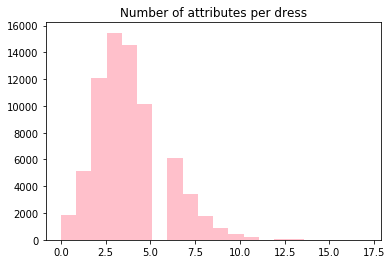

In [19]:
# plot distribution as histogram
plt.hist(attr_per_dress_count, color='pink', bins=20)
plt.title('Number of attributes per dress')
plt.show()

It looks like most of the dresses have between 2 and 5 attributes.

So far the dataframe has all attributes from the full clothing data. However, not all of these attributes are relevant for the dresses. Let's see which ones build up the majority. The results will be also ploted on histogram.

In [20]:
# count number of dresses having each attribute
dress_per_attr_count = cloth_attr.sum(axis=0, skipna=True)

In [21]:
# sort the values
dress_per_attr_count = dress_per_attr_count[1:].sort_values(ascending=False)

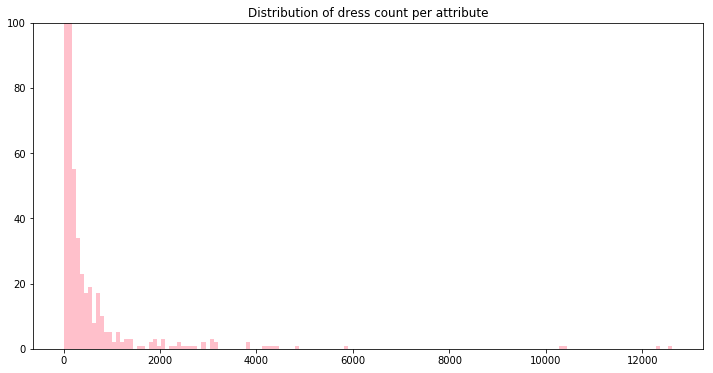

In [22]:
# plot the results
plt.figure(figsize=[12,6])
plt.hist(list(dress_per_attr_count.values),bins=150, color = 'pink')
plt.title('Distribution of dress count per attribute')
plt.ylim([0,100])
plt.show()

Lots of attributes are only present in few if any dresses. I will filter for the attributes that are found in at least 1000 dresses each and will then break these attributes into groups.

In [24]:
# filter for attributes that are present in at least 1000 dresses
dress_per_attr_count[(dress_per_attr_count >= 1000).values]

maxi                              12620
print                             12347
floral                            10372
lace                              10345
bodycon                            5824
shift                              4836
sleeve                             4426
chiffon                      2     4325
fit                                4224
flare                              4196
sleeveless                         3825
skater                             3803
floral print                       3175
knit                               3129
sheath                             3096
strapless                          3096
crochet                            3052
embroidered                        2939
midi                               2886
striped                            2699
summer                             2623
pleated                            2600
mini                               2507
cami                               2392
stripe                             2367


Few attributes are represented twice, lie 'print' and 'printed'. I am combining them into one attribute.

In [25]:
# combine 'print' and 'printed', and 'stripe' and 'striped'
cloth_attr['printed'] = cloth_attr[['printed', 'print']].max(axis=1)
cloth_attr['striped'] = cloth_attr[['striped', 'stripe']].max(axis=1)

In [26]:
# fix column names
cloth_attr.rename(columns={'chiffon                      2':'chiffon', 
                           'sheer                        2': 'sheer'}, inplace=True)

I will be using attributes that have at least 1000 images with it. Attributes can be divided into several groups:

 - Length: 
     - maxi
     - midi
     - mini
     
 - Sleeve:
     - sleeve
     - sleeveless
     - long sleeve
    
 - Full body shape:
     - bodycon
     - fit 
     - flare
     - skater
     - shift
     - sheath
     - belted
     - shirt
     - babydoll
     
 - Top shape:
     - v-neck
     - shoulder
     - sweetheart
     
 - Bottom shape:
     - a-line
     - slit
     
 - Print:
     - printed
     - floral
     - striped
     - abstract
     - tribal
     - paisley
     - rose
     
 - Material:
     - chiffon
     - lace
     - floral lace
     - cotton
     - denim
     
 - Look:
     - mesh
     - beaded
     - textured
     - trim
     - pleated
     - sheer
     
Below I will take a quick look into each attribute with low resolution versions of images to save on memory. I will be printing 5 random images of each attribute.
     

In [27]:
# define functions

def get_attr_index(attr):
    """Returns a list of indexes which have a given attribute"""
    return cloth_attr[cloth_attr[attr]==1].index

def print_image(ind):
    """Prints image of a given index"""
    img = mpimg.imread('data/img/'+cloth_attr.loc[ind,'url'])
    plt.imshow(img)
    del img

def print_5_images(attr_list):
    """Prints 5 random images for each attribute in a given list of attribute names"""
    l = len(attr_list)
    j = 1 #index to move along subplots
    plt.figure(figsize=[15,5*l])
    for ind in range(l):
        print_ind = get_attr_index(attr_list[ind])
        for i in range(5):
            plt.subplot(l,5,j)
            j += 1
            n = random.randint(0,1000)
            print_image(print_ind[n])
            plt.title(attr_list[ind])
    

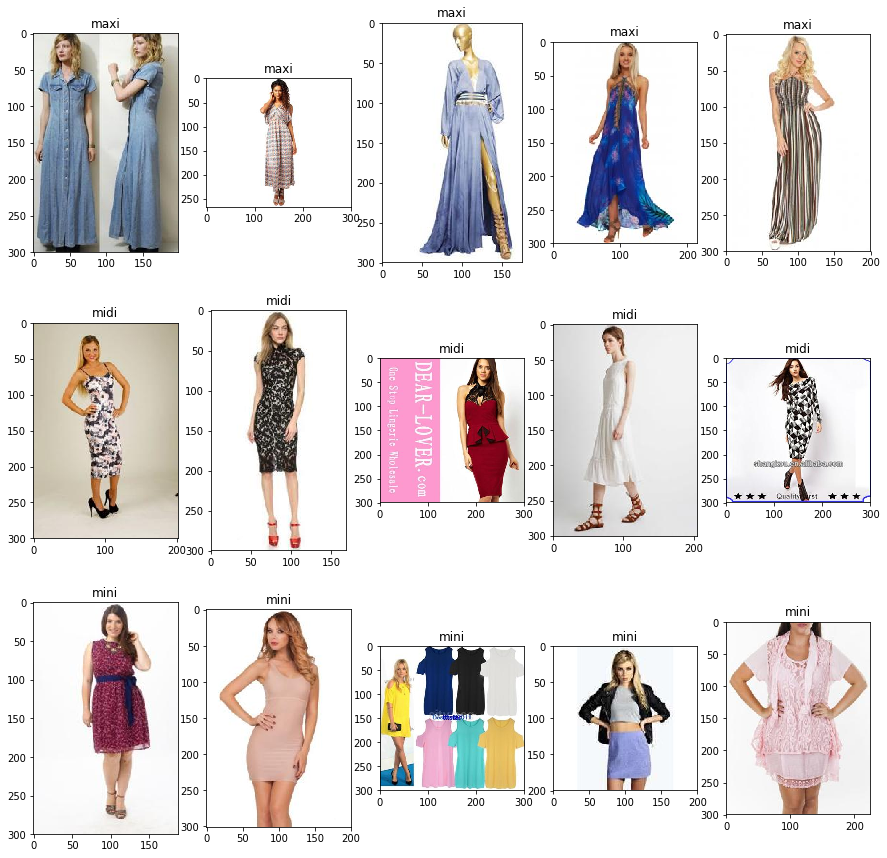

In [28]:
# show length
length = ['maxi', 'midi', 'mini']
print_5_images(length)
        

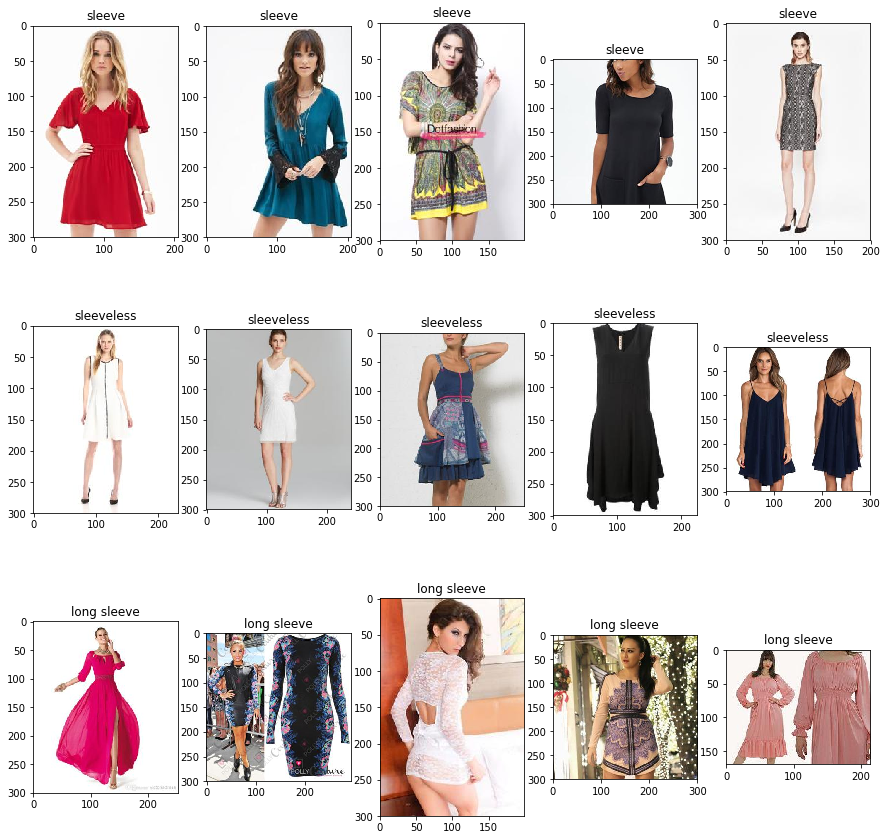

In [29]:
# show sleeve category
sleeve = ['sleeve', 'sleeveless', 'long sleeve']
print_5_images(sleeve)

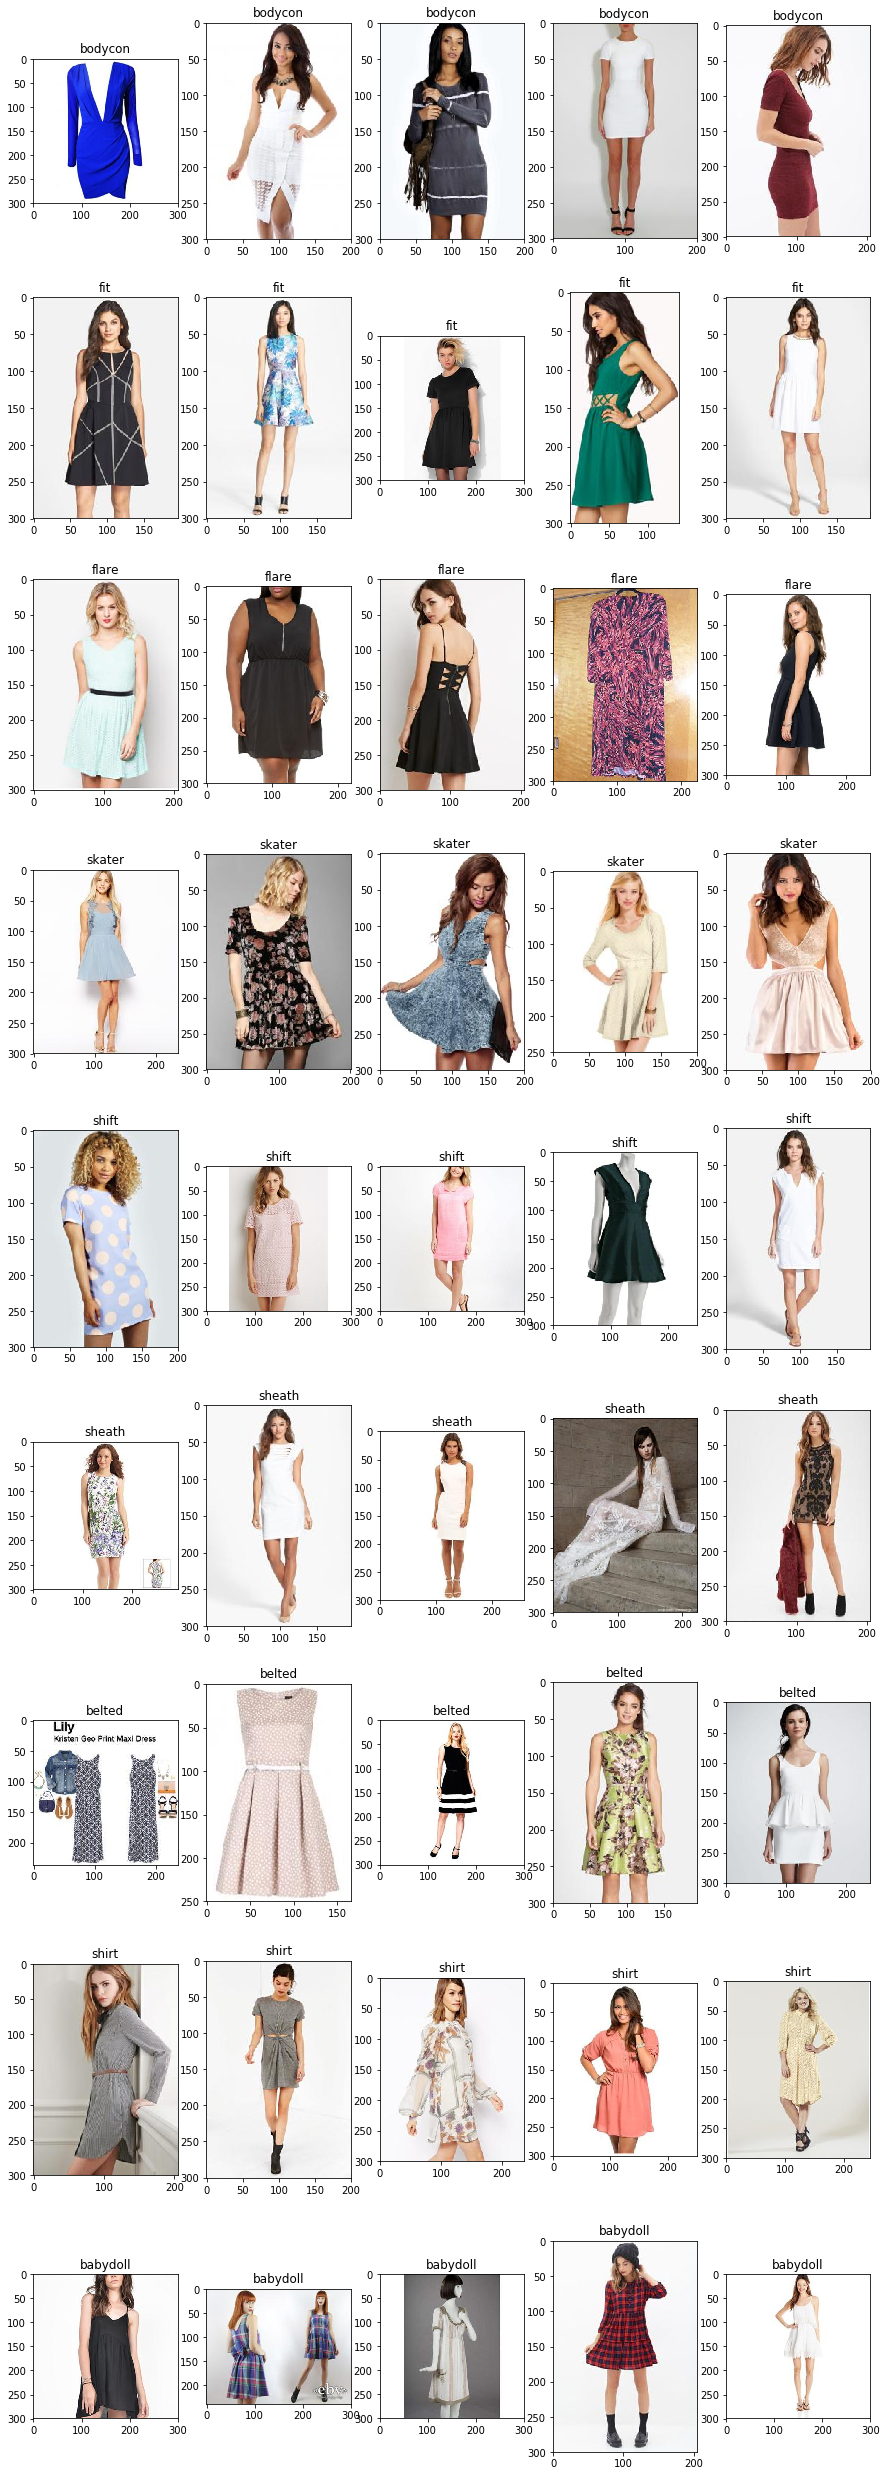

In [30]:
# body shape
body_shape = ['bodycon', 'fit', 'flare', 'skater', 'shift', 'sheath', 'belted', 'shirt', 'babydoll']
print_5_images(body_shape)

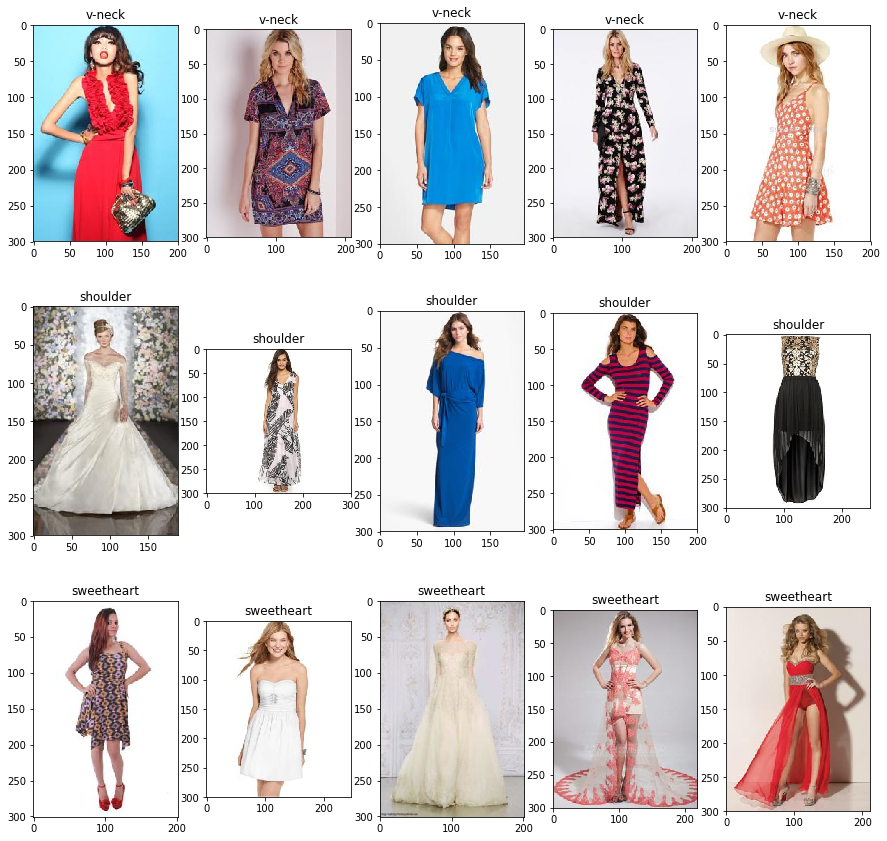

In [31]:
# show variations of the top shape
top_shape = ['v-neck', 'shoulder', 'sweetheart']
print_5_images(top_shape)

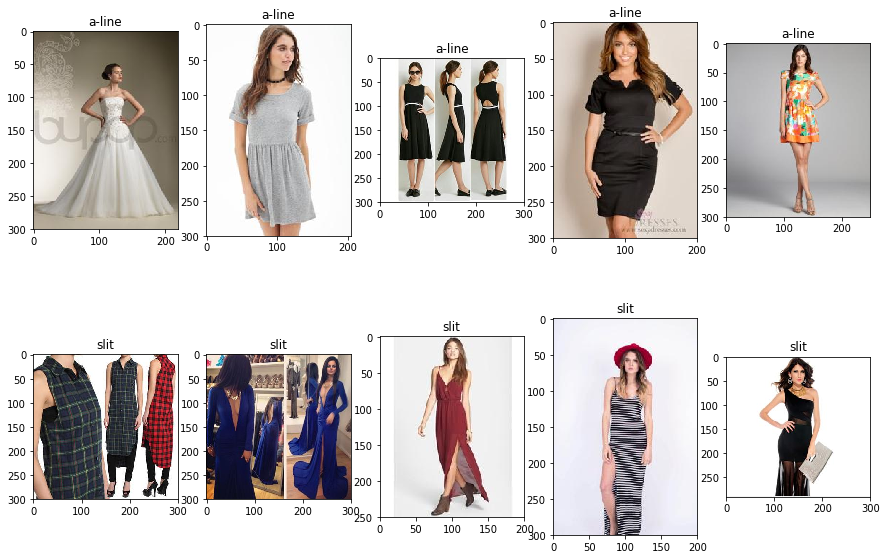

In [32]:
# show different bottom shapes
bottom_shape = ['a-line', 'slit']
print_5_images(bottom_shape)

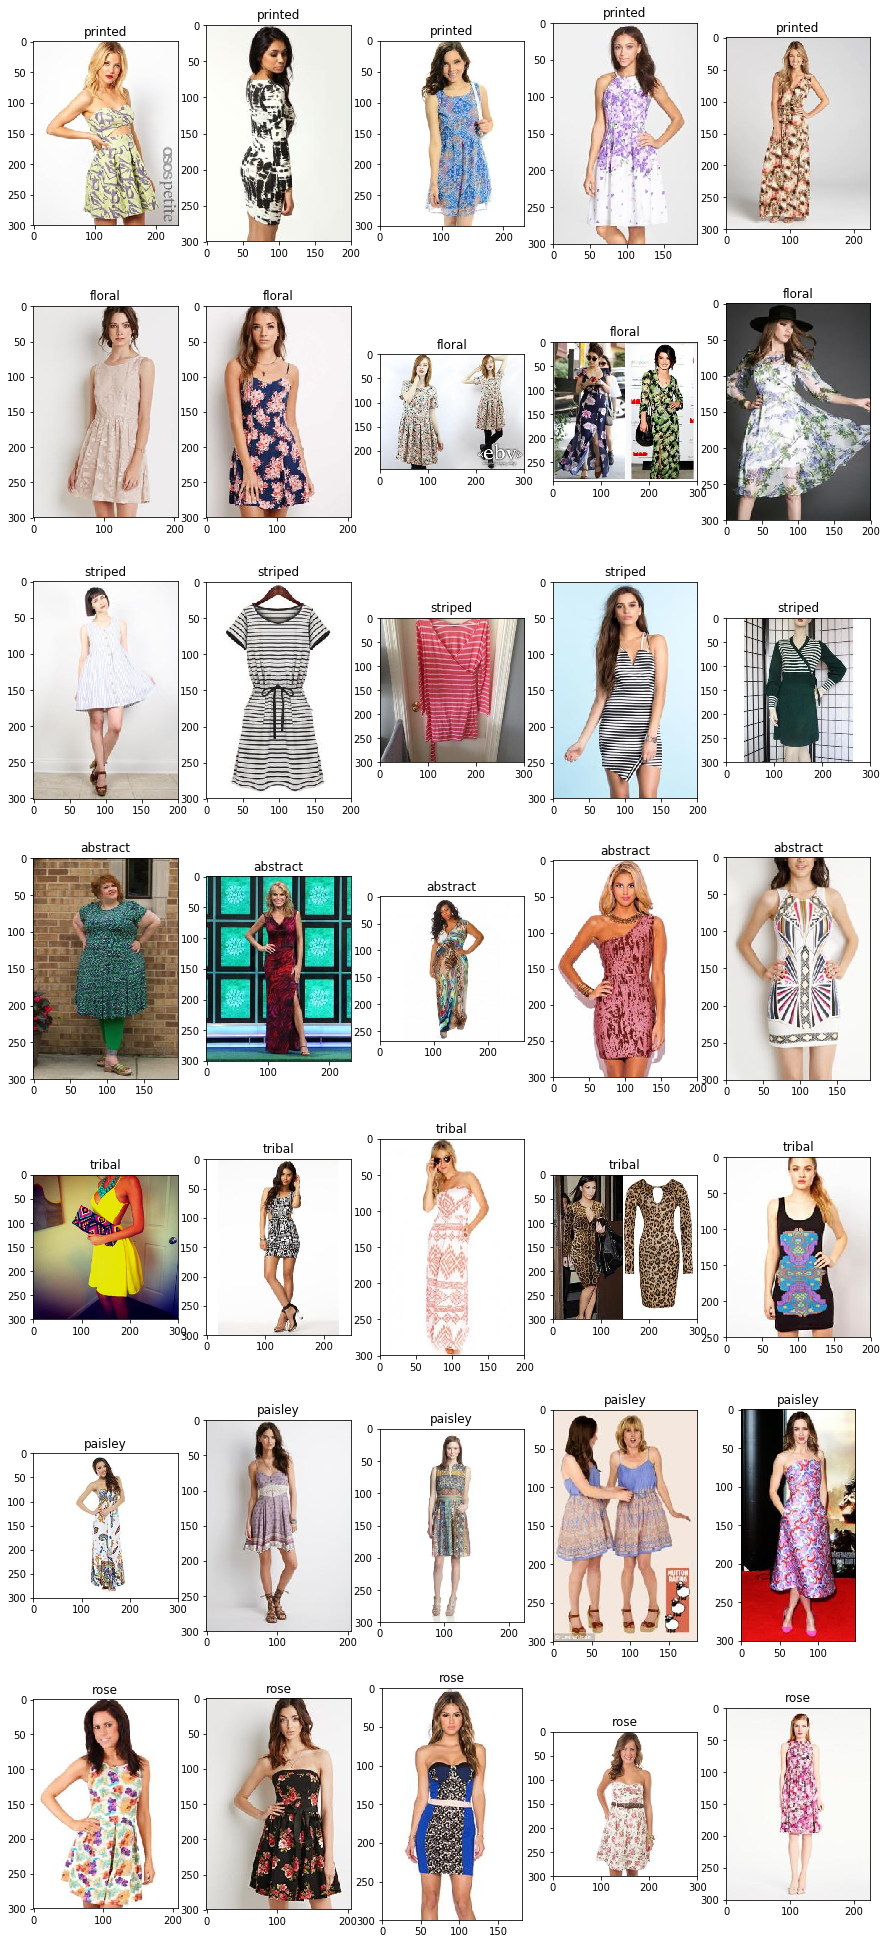

In [33]:
# show variations of print patterns
print_pattern = ['printed', 'floral', 'striped', 'abstract', 'tribal', 'paisley', 'rose']
print_5_images(print_pattern)

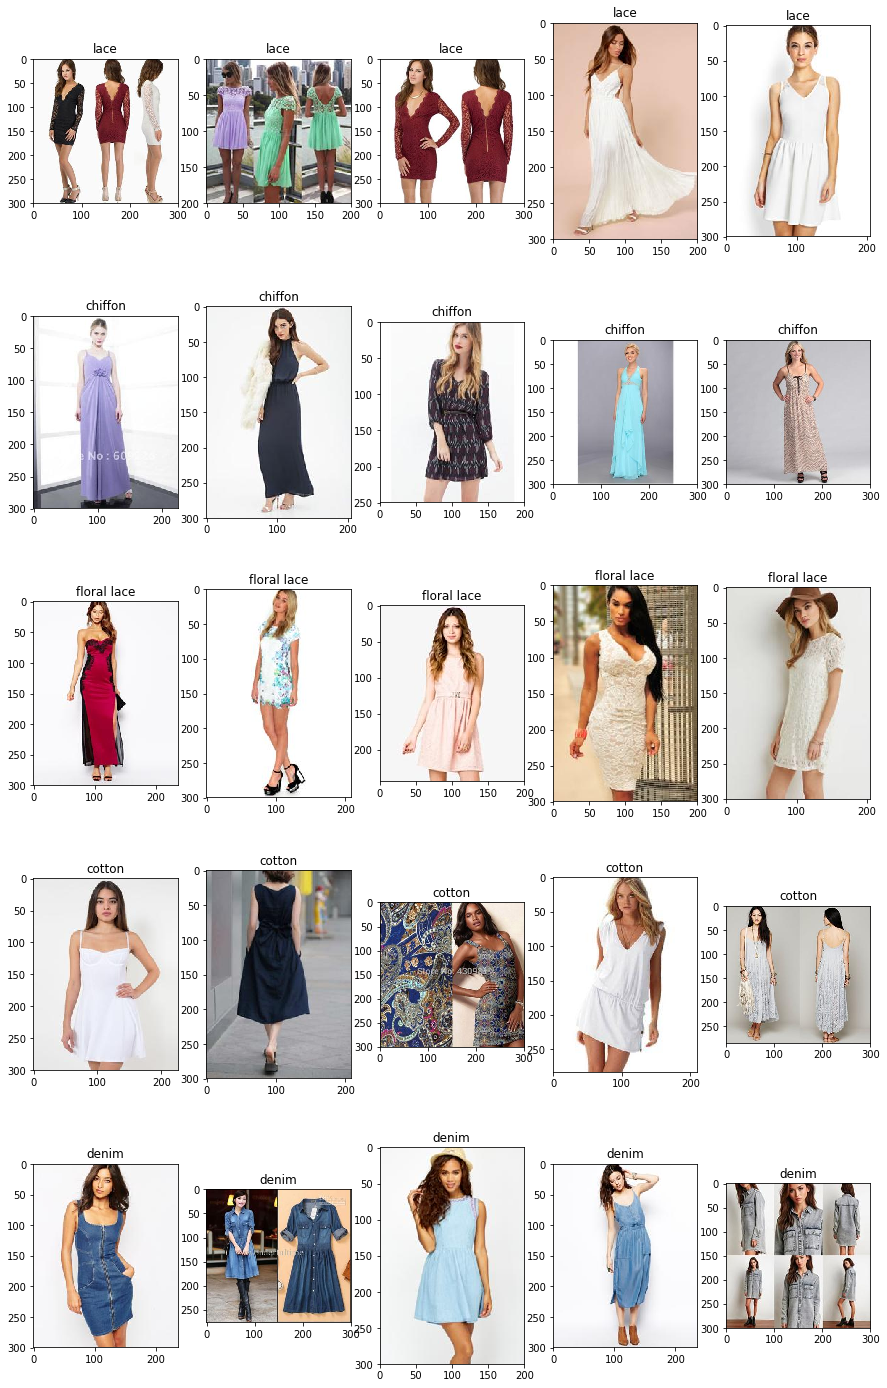

In [34]:
# show material variations
material = ['lace', 'chiffon', 'floral lace', 'cotton', 'denim']
print_5_images(material)

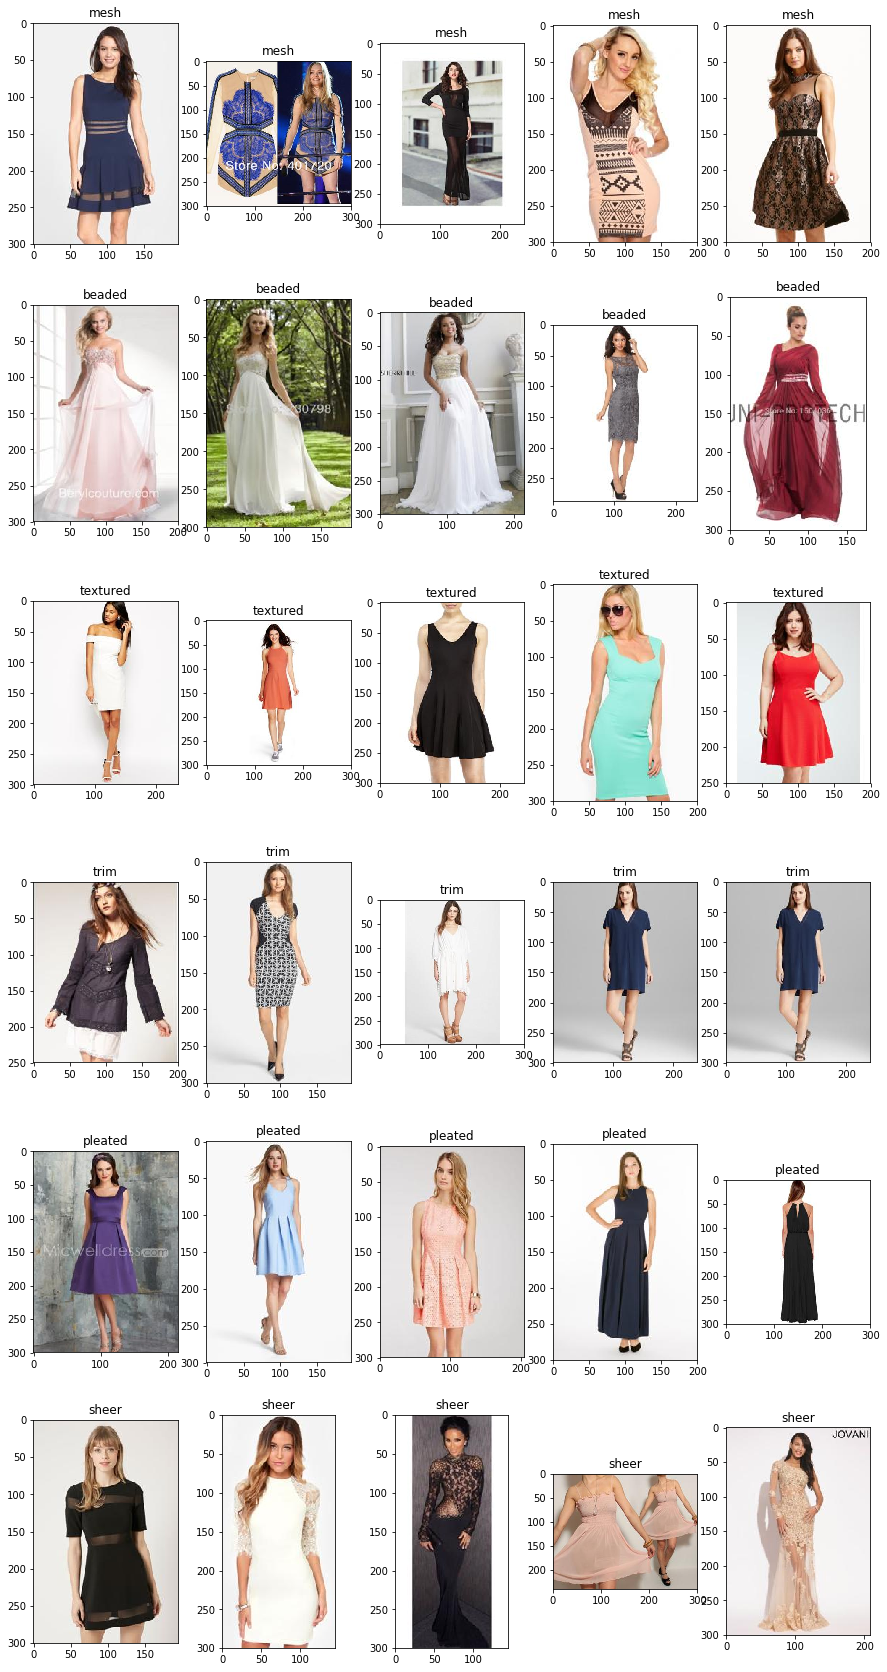

In [35]:
# look variations
look = ['mesh', 'beaded', 'textured', 'trim', 'pleated', 'sheer']
print_5_images(look)

Most of the images printed above showcase really well the attribute that they belong to. Some of the attributes provide very similar looks (e.g. 'fit' and 'flare', 'shift' and 'sheath', 'floral' and 'rose' etc.). For now I will keep them as separate columns, but as part of model optimization they can be combined.

Further I will only keep the columns of attributes discussed and illistrated above and also remove dresses with no attributes at all.

In [40]:
# filter for needed attributes
dress_attr = cloth_attr.loc[:,['url','maxi', 'midi', 'mini', 'sleeve', 'sleeveless', 'long sleeve', 'bodycon', 'fit', 
                               'flare', 'skater', 'shift', 'sheath', 'belted', 'shirt', 'babydoll', 'v-neck', 'shoulder',
                              'sweetheart', 'a-line', 'slit', 'printed', 'floral', 'striped', 'abstract', 'tribal', 
                               'paisley', 'rose', 'lace', 'chiffon', 'floral lace', 'cotton', 'denim', 'mesh', 'beaded',
                              'textured', 'trim', 'pleated', 'sheer']]

In [41]:
# drop columns with none of selected attributes
count_attr = dress_attr.sum(axis=1, skipna=True)
get_ind = dress_attr[count_attr==0].index
final_dress_attr = dress_attr.drop(get_ind,axis=0)

# print the shape
final_dress_attr.shape

(61414, 39)

In [42]:
# save attribute file
final_dress_attr.to_csv('data/dress_attributes.csv')

We are down to 61,414 dresses - still a pretty good number of images.

Let's now see how many attributes each dress has.

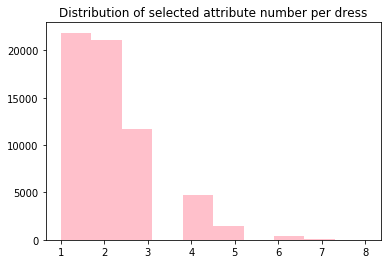

In [39]:
count_attr = final_dress_attr.sum(axis=1, skipna = True)

#histogram of number of attributes per dress
plt.hist(count_attr, color = 'pink')
plt.title('Distribution of selected attribute number per dress')
plt.show()

Most of the dresses have either one or two attributes. A large number of dresses also has 3 attributes. Further I will take a look at image shapes for both low and high resolution versions.